# Neural Network from keras

In [1]:
#import libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import sklearn 
from sklearn.model_selection import train_test_split
import time
import os
import pickle
from keras import models, layers, optimizers, regularizers
import matplotlib.pyplot as plt
import sklearn

2023-02-25 12:35:59.214666: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
#load data
version_data = "003"
path_data = f'../../data/preprocessed/{version_data}/' 
(x_test, x_train, y_test, y_train, x_predict) = [np.load(f'{path_data}{f}.npy', allow_pickle=True) 
                                                for f in ('X_test', 'X_train', 'y_test', 'y_train',  'X_predict')]
                                                
#split data
y_train=np.asarray(y_train)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)  

y_train = y_train.reshape((y_train.shape[0],1)) *1
y_val = y_val.reshape((y_val.shape[0],1)) *1
y_test = y_test.reshape((y_test.shape[0],1)) *1

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1])) *1
x_val = x_val.reshape((x_val.shape[0], x_val.shape[1])) *1


y_train = tf.convert_to_tensor(y_train,dtype=tf.float32)
y_val = tf.convert_to_tensor(y_val,dtype=tf.float32)
x_train = tf.convert_to_tensor(x_train,dtype=tf.float32)
x_val = tf.convert_to_tensor(x_val,dtype=tf.float32)

print(f'x_train.shape: {x_train.shape}')
print(f'x_val.shape: {x_val.shape}')
print(f'x_test.shape: {x_test.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'y_val.shape: {y_val.shape}')
print(f'y_test.shape: {y_test.shape}')

x_train.shape: (240469, 100)
x_val.shape: (60118, 100)
x_test.shape: (75147, 100)
y_train.shape: (240469, 1)
y_val.shape: (60118, 1)
y_test.shape: (75147, 1)


### KERAS
--> Deep Neural Network

Train model

In [45]:
#define model

model = keras.Sequential([
                            keras.layers.Dense(x_train.shape[1], activation='tanh', input_shape=[len(x_train[1])]),
                            keras.layers.Dense(128, activation='relu'),
                            keras.layers.Dropout(0.1),
                            keras.layers.Dense(64, activation='relu'),
                            keras.layers.Dropout(0.3),
                            #keras.layers.Dense(32, activation='relu'),
                            #keras.layers.Dropout(0.5),
                            keras.layers.Dense(16, activation='relu'),
                            keras.layers.Dense(1, activation='linear')
                                ])

K_RMSE = tf.keras.metrics.RootMeanSquaredError(name='K_RMSE', dtype=None)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005, epsilon=1e-08),
                loss='mse',
                metrics=[K_RMSE, 'mse'])

# Model weights are saved at the end of every epoch,
    # if it's the best seen so far.
checkpoint_filepath = '../../models/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_K_RMSE',
    mode='min',
    save_best_only=False)            

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               10100     
                                                                 
 dense_1 (Dense)             (None, 128)               12928     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 16)                1040      
                                                                 
 dense_4 (Dense)             (None, 1)                 1

In [42]:
tf.keras.backend.clear_session()
start_time = time.time()  #track the model development time
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=50, callbacks=[model_checkpoint_callback], batch_size=2048)
end_time = time.time()
duration = end_time - start_time
print("Training duration: %s sec" % (duration)) 
model.load_weights(checkpoint_filepath)

Epoch 1/50
118/118 [==============================] - 1s 9ms/step - loss: 62.9799 - K_RMSE: 7.9360 - mse: 62.9799 - val_loss: 4.5998 - val_K_RMSE: 2.1447 - val_mse: 4.5998
Epoch 2/50
118/118 [==============================] - 1s 9ms/step - loss: 8.0336 - K_RMSE: 2.8344 - mse: 8.0336 - val_loss: 2.1129 - val_K_RMSE: 1.4536 - val_mse: 2.1129
Epoch 3/50
118/118 [==============================] - 1s 9ms/step - loss: 6.0923 - K_RMSE: 2.4682 - mse: 6.0923 - val_loss: 1.6518 - val_K_RMSE: 1.2852 - val_mse: 1.6518
Epoch 4/50
118/118 [==============================] - 1s 11ms/step - loss: 5.3170 - K_RMSE: 2.3059 - mse: 5.3170 - val_loss: 1.5436 - val_K_RMSE: 1.2424 - val_mse: 1.5436
Epoch 5/50
118/118 [==============================] - 1s 13ms/step - loss: 4.8253 - K_RMSE: 2.1967 - mse: 4.8253 - val_loss: 1.4171 - val_K_RMSE: 1.1904 - val_mse: 1.4171
Epoch 6/50
118/118 [==============================] - 1s 12ms/step - loss: 4.4408 - K_RMSE: 2.1073 - mse: 4.4408 - val_loss: 1.5841 - val_K_RMSE: 

In [43]:
#predict
y_predict = model.predict(x_test)
RMSE = sklearn.metrics.mean_squared_error(y_test, y_predict, squared=False)
print('RMSE (test): ', RMSE)

2349/2349 [==============================] - 2s 651us/step
RMSE (test):  4.500194984868996


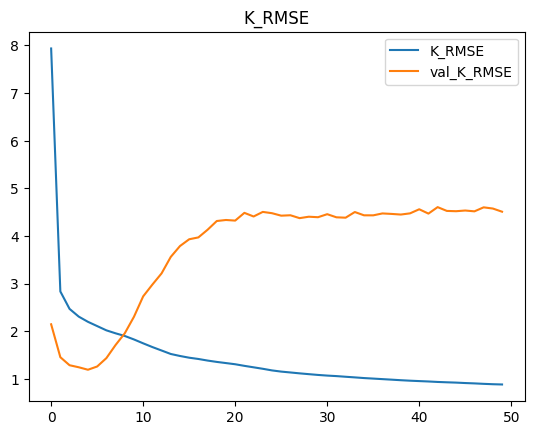

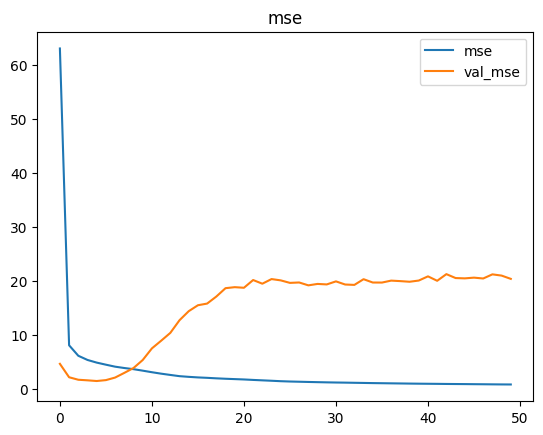

In [44]:
for metric in ['K_RMSE', 'mse']:
    plt.plot(history.history[metric], label=metric)
    plt.plot(history.history['val_' + metric], label='val_' + metric)
    plt.legend()
    plt.title(f"{metric}")
    plt.show()

tf.keras.backend.clear_session()

SAVE MODEL

In [19]:
model_id = 'TF__'+ version_data + '__02'
print(f"Saving model {model_id} ...")

#save model
if not os.path.exists(f'../../models/{model_id}'):
        os.mkdir(f'../../models/{model_id}')
pickle.dump(model, open(f'../../models/{model_id}/model.pkl', 'wb'))

#save results
timestamp = time.strftime("%Y_%m_%d at %H_%M")
print(timestamp)
print(f'RMSE: {RMSE}')

overview = pd.read_csv('../../models/prediction_overview.csv')
new_row = {'model_id': model_id, 'timestamp': timestamp, 'error': RMSE}
overview = pd.concat([overview, pd.DataFrame(new_row, index=[0])])
overview = overview[{'model_id', 'timestamp', 'error'}]
overview.drop_duplicates(inplace=True)
print(overview)
overview.to_csv('../../models/prediction_overview.csv')

Saving model TF__001__02 ...
INFO:tensorflow:Assets written to: ram://baeaff04-d1f8-4c1d-8bd9-c184b019f577/assets
2023_01_31 at 17_46
RMSE: 5.2784550038315
             model_id            timestamp          error
0  xgboost__first__01  2023_01_06 at 15_52            NaN
1  xgboost__first__02  2023_01_30 at 13_10            NaN
2  xgboost__first__02  2023_01_30 at 13_11       0.259323
3       TF__first__01  2023_01_30 at 14_17  724579.241582
4       TF__first__01  2023_01_30 at 14_27       9.875672
5    xgboost__001__02  2023_01_31 at 17_05       0.292051
6    xgboost__001__02  2023_01_31 at 17_08       0.744116
7         TF__001__02  2023_01_31 at 17_45       5.278455
0         TF__001__02  2023_01_31 at 17_46       5.278455


/tmp/ipykernel_10649/1350543180.py:17: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  overview = overview[{'model_id', 'timestamp', 'error'}]
